<a href="https://colab.research.google.com/github/ibombonato/kaggle-sorghum-100-cultivar/blob/main/vit-transformers-sorghum-100-cultivar-starter-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple baseline with ViT Transformers + Hugging Face + Lightning

This notebook shows the use of Hugging Face, Pytorch and Pytorch Lightning to train a classifier with ViT Transformers architecture.

It is based/inspired on the [HuggingPics](https://github.com/nateraw/huggingpics) project and uses a rezised and adjusted labels by folder dataset

https://www.kaggle.com/ibombonato/sorghum-100-cultivar-512x512-png-imagefolder

**If it helps you in some manner, please upvote the dataset and the notebook :D**

In [38]:
!nvidia-smi

Wed Mar 23 01:34:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    29W /  70W |   2576MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Colab Setup

In [1]:
!pip install -q wandb python-dotenv kaggle pytorch-lightning transformers

     |████████████████████████████████| 1.7 MB 12.6 MB/s 
     |████████████████████████████████| 527 kB 59.8 MB/s 
     |████████████████████████████████| 3.8 MB 36.1 MB/s 
     |████████████████████████████████| 181 kB 51.9 MB/s 
     |████████████████████████████████| 144 kB 54.3 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 397 kB 18.9 MB/s 
     |████████████████████████████████| 596 kB 50.5 MB/s 
     |████████████████████████████████| 952 kB 14.5 MB/s 
     |████████████████████████████████| 829 kB 14.5 MB/s 
     |████████████████████████████████| 134 kB 53.2 MB/s 
     |████████████████████████████████| 1.1 MB 47.9 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 6.5 MB 57.8 MB/s 
     |████████████████████████████████| 895 kB 61.5 MB/s 
     |████████████████████████████████| 144 kB 57.6 MB/s 
     |████████████████████████████████| 271 kB 65.2 MB/s 
     |████████████

In [2]:
from google.colab import files 
from dotenv import load_dotenv
import os
from pathlib import Path

In [3]:
if Path("dev.env").exists():
  load_dotenv("dev.env")
else:
  env_file = files.upload()
  for item in env_file.keys():
    load_dotenv(f"{item}")

Saving dev.env to dev.env


In [4]:
!kaggle datasets download ibombonato/sorghum-100-cultivar-512x512-png-imagefolder -p /content/data

100% 16.4G/16.4G [03:34<00:00, 94.6MB/s]
100% 16.4G/16.4G [03:34<00:00, 81.8MB/s]


In [5]:
!unzip -q /content/data/sorghum-100-cultivar-512x512-png-imagefolder.zip -d /content/data/

In [6]:
!kaggle kernels output ibombonato/vit-transformers-sorghum-100-cultivar-starter -p /content/output/

Output file downloaded to /content/output/checkpoints/epoch=4-step=4384.ckpt
Output file downloaded to /content/output/cultivar_baseline_epoch_5_vit_transformer.ckpt
Output file downloaded to /content/output/submission.csv
Kernel log downloaded to /content/output/vit-transformers-sorghum-100-cultivar-starter.log 


### Load libs and minimal setup

In [7]:
!pip install -q timm
!pip install -q --upgrade wandb wandb[service]

     |████████████████████████████████| 431 kB 14.9 MB/s 


In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from tqdm.auto import tqdm
from PIL import Image, UnidentifiedImageError
from pathlib import Path

tqdm.pandas()

In [28]:
ORIGIN_FOLDER = "/content/data/images"
USE_WANDB = False
EPOCHS = 50
MODEL_NAME = 'google/vit-base-patch16-224-in21k'

In [10]:
train_raw = pd.read_csv(Path(ORIGIN_FOLDER, "train_cultivar_mapping.csv"))

In [11]:
import matplotlib.pyplot as plt
import shutil
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import AutoFeatureExtractor, ViTForImageClassification
from torchvision.transforms import ToTensor
import torchvision
from torchvision.io import read_image
import random
from timm.data import ImageDataset
from sklearn.model_selection import StratifiedShuffleSplit

## Loading the data

Since we are using a [dataset](https://www.kaggle.com/ibombonato/sorghum-100-cultivar-512x512-png-imagefolder) that has all imades grouped by folders/labels, we can use `ImageFolder` from `torchvision.datasets` to load the dataset and simplify the process.

~~We will use `random_split` from Pytorch to split the Images into train and validation sets.~~

In [12]:
all_ds = ImageFolder(Path(ORIGIN_FOLDER, "train"))

Lets add some transformation to the images, this will help our model to generalize better and also help with overfit

In [13]:
from torchvision import transforms
# For training, we add some augmentation. Networks are too powerful and would overfit.

feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_NAME)
normalize = transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

train_transform = transforms.Compose(
    [
        transforms.RandomAffine(0.75),
        transforms.ColorJitter(brightness=0.5, contrast=0.25),
        transforms.RandomAutocontrast(0.25),
        transforms.RandomRotation(0.15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(feature_extractor.size, scale=(0.6, 1), ratio=(0.5, 2)),
        normalize
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize(feature_extractor.size),
    ]
)

We will use `StratifiedShuffleSplit` from `sklearn` to split the Images into train and validation sets in a stratified way, label proportions are keept in the split.

We also need to create a `Subset` that we can use differente transforms for train and validation

In [14]:
# https://stackoverflow.com/questions/51782021/how-to-use-different-data-augmentation-for-subsets-in-pytorch
# Subset with transform, so we can have a train and val transform
class Subset(Dataset):
    r"""
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
        transform (Transformation): Vision Transforms to apply in the image
    """
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        im, labels = self.dataset[self.indices[idx]]
        if self.transform:
            im = self.transform(im)
        return im, labels

    def __len__(self):
        return len(self.indices)

In [15]:
def train_test_dataset(dataset, test_split, train_transform, val_transform):
    X = dataset.imgs
    y = dataset.targets
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_split, random_state=42)
    train_idx, val_idx = next(sss.split(X, y))
    
    train_ds = Subset(dataset, train_idx, train_transform)
    val_ds = Subset(dataset, val_idx, val_transform)
    return train_ds, val_ds

train_ds, val_ds = train_test_dataset(all_ds, 0.2, train_transform, val_transform)

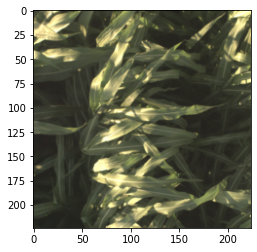

In [16]:
# plot a random image
img, label = train_ds[random.randint(0, len(train_ds))]
plt.imshow(img, cmap="gray")

Since pytorch will convert targets to numeric, we will map ids to labels and labels to ids, so we can get/acess the class names in the future.

In [17]:
label2id = {}
id2label = {}

for i, class_name in enumerate(all_ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [18]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
 
    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings

In [19]:
#feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_NAME)
model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)

collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, collate_fn=collator, num_workers=2)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy()

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

Setting up teh logger with Wandb

In [ ]:
# FOR THIS TO WORK, YOU NEED TO SET YOUR API KEY IN THE KAGGLE SECRETS ENVIRONMENT!
import os
from pytorch_lightning.loggers import WandbLogger
from kaggle_secrets import UserSecretsClient
import wandb

if USE_WANDB:
    project_name = "kaggle-sorghum-100-cultivar"
    user_secrets = UserSecretsClient()
    wandb.require(experiment="service")
    wandb.login(key=user_secrets.get_secret("WANDB_API_KEY"))
       
    model_logger = WandbLogger(project=project_name, version='0.2', log_model=True, experiment='5 epochs', config={"epochs": EPOCHS})
else:
    model_logger=None

In [21]:
model_logger=None

Train the model

In [22]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(gpus=1, precision=16, max_epochs=EPOCHS, logger=model_logger)

Global seed set to 42
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1080: LightningDeprecationWarning: `trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
  "`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LR finder stopped early after 17530 steps due to diverging loss.
Restoring states from the checkpoint path at /content/lr_find_temp_model_4d0c95ca-a4af-48f0-bfbf-558126063107.ckpt
Failed to compute suggesting for `lr`. There might not be enough points.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7

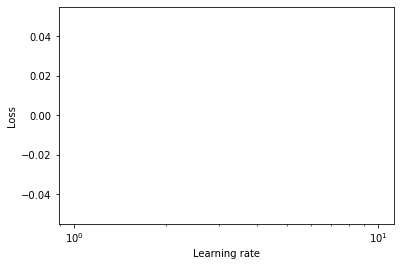

In [26]:
lr_finder = trainer.tuner.lr_find(classifier, train_dataloader=train_loader)
fig = lr_finder.plot(); fig.show()
suggested_lr = lr_finder.suggestion()
suggested_lr

In [29]:
trainer.

AttributeError: ignored

In [30]:
#classifier = Classifier(model, lr=suggested_lr)
trainer = pl.Trainer(gpus=1, precision=16, max_epochs=EPOCHS, logger=model_logger)
trainer.fit(classifier, train_loader, val_loader)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                      | Params
------------------------------------------------------
0 | model   | ViTForImageClassification | 85.9 M
1 | val_acc | Accuracy                  | 0     
------------------------------------------------------
85.9 M    Trainable params
0         Non-trainable params
85.9 M    Total params
171.751   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [37]:
trainer.save_checkpoint(f"cultivar_baseline_epoch_{EPOCHS}_vit_transformer.ckpt")

In [ ]:
trainer.save_checkpoint(f"cultivar_baseline_epoch_20_vit_transformer.ckpt")

In [ ]:
if USE_WANDB: wandb.finish()

# Make predictions

Now we will make predictions on the test set.

After make some adjustments, I could score it via batch and reduce the time **from 4 hours to 6 minutes :D**

~~A working to improve here is to score the test set via batch and not one to one.~~

The old code are collapsed bellow for reference.

In [ ]:
# OLD CODE, JUST FOR REFERENCE, DO NOT USE IT!
# It takes over 4 hours to do inference on all test images :-/

# def pred_image(img):
    
#     if not Path(img).exists(): return ''
    
#     im = Image.open(img)
#     # Transform our image and pass it through the model
#     inputs = feature_extractor(im, return_tensors='pt')
#     with torch.no_grad():
#         output = model(**inputs)

#     # Predicted Class probabilities
#     proba = output.logits.softmax(1)

#     # Predicted Classes
#     preds = proba.argmax(1)

#     return model.config.id2label[str(preds.item())]

# model.eval()

# TEST_FOLDER = "../input/sorghum-id-fgvc-9/test"

# test_df = pd.read_csv("../input/sorghum-id-fgvc-9/sample_submission.csv")

# test_df['cultivar'] = test_df.filename.progress_apply(lambda x: pred_image(f"{TEST_FOLDER}/{x}"))

# test_df.to_csv("submission.csv", index = False)


In [31]:
TEST_FOLDER = "/content/data/images/test"

test_ds = ImageDataset(Path(TEST_FOLDER))
test_dl = DataLoader(test_ds, batch_size=32, collate_fn=collator, num_workers=2)

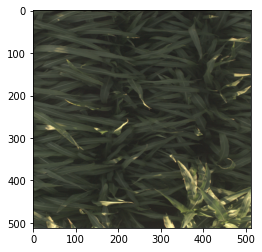

In [32]:
# plot a random image from test set
img, label = test_ds[random.randint(0, len(test_ds))]
plt.imshow(img, cmap="gray")

In [33]:
model.cuda()
model.eval()

def batch_predictions(dl, ds, id2label):
    predictions = []
    for batch in tqdm(dl):
        image = batch['pixel_values'].cuda()
        with torch.no_grad():
            outputs = model(image)
            preds = outputs.logits.softmax(1).argmax(1).detach().cpu().numpy()
            predictions.append(preds)
        
    all_preds = []
    for batch in predictions:
        for prediction in batch:
            all_preds.append(id2label[str(prediction)])

    return all_preds, ds.filenames()

In [34]:
batch_preds, batch_filenames = batch_predictions(test_dl, test_ds, id2label)
df_preds = pd.DataFrame({'filename': batch_filenames, "cultivar": batch_preds})
df_preds.head()

  0%|          | 0/739 [00:00<?, ?it/s]

,filename,cultivar
0,88028.png,PI_155760
1,181578.png,PI_22913
2,320611.png,PI_152961
3,350168.png,PI_155760
4,492639.png,PI_92270


# Submisson

At the moment, the testset or the sample_submission are broken and its not possible to submit. As soon as the organizers fix it, I will update with the submission.


In [35]:
test_df = pd.read_csv("/content/output/submission.csv")

submission_df = pd.merge(test_df[['filename']], df_preds, how='inner', on='filename')

submission_df.to_csv("submission.csv", index = False)

submission_df.head()

,filename,cultivar
0,1000005362.png,PI_180348
1,1000099707.png,PI_196049
2,1000135300.png,PI_92270
3,1000136796.png,PI_329256
4,1000292439.png,PI_156393


In [36]:
from google.colab import files

files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## TO DO:

- ~~Make inference faster~~
- ~~Find best learning rate~~
- ~~Add augmentation~~
- ~~Better split strategy~~
- Add CrossValidation
- Make Wandb Work (I am getting an error right now with the logger in `self.experiment.config.update(params, allow_val_change=True)`)
- Load from checkpoint?

## If it helps you in some manner, please upvote the dataset and the notebook :D